In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import os

folder = "dataset/v1.0-mini_processed/scene-0061_cc8c0bf57f984915a77078b10eb33198/61dd7d03d7ad466d89f901ed64e2c0dd"
colmap_folder = "dataset/v1.0-mini_processed/scene-0061_cc8c0bf57f984915a77078b10eb33198/colmap_out/61dd7d03d7ad466d89f901ed64e2c0dd_simple2"

### Read data

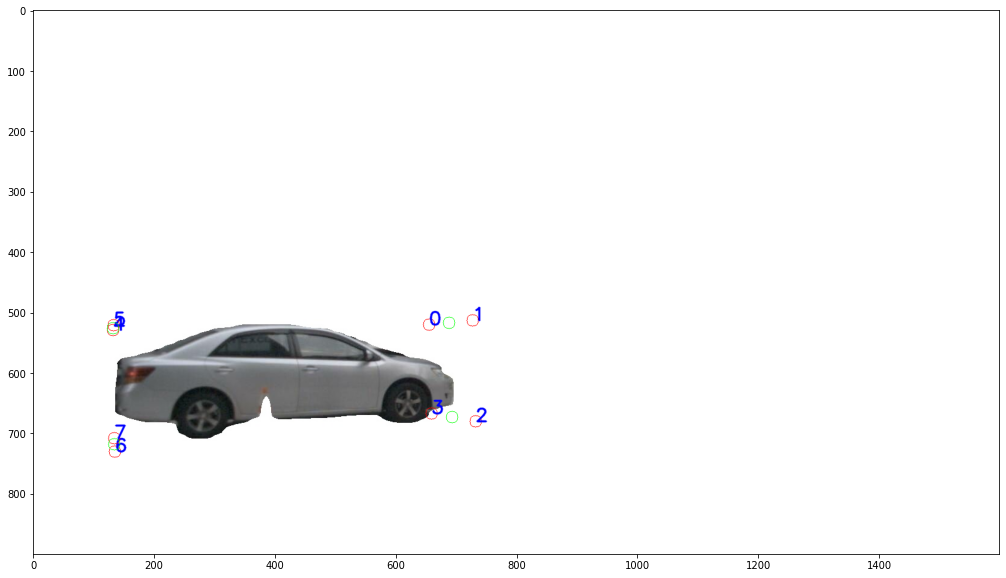

In [123]:

img = cv2.cvtColor(cv2.imread(os.path.join(colmap_folder, "images/0_00002.jpg")), cv2.COLOR_BGR2RGB)
with open(os.path.join(folder, "1ba0378c211e4c49b1abe6f26fc41acb.json"), "r") as f:
    data = json.load(f)
box_3d = np.array(data["car_box_3d_cam"])
P = np.array(data["P"])
intrinsics = np.array(data["camera_intrinsic"])

# vertical plane
plane_point_pairs = [[0,1], [2,3], [4,5], [6,7]]
plane_points = []
for pair1, pair2 in plane_point_pairs:
    plane_points.append((box_3d[:,pair1]+box_3d[:,pair2])/2)
plane_points = np.array(plane_points).T

# find pixels on the image
unnormalized_2d_points = (intrinsics@box_3d).T
norm_2d_points = unnormalized_2d_points / unnormalized_2d_points[:,-1].reshape(len(unnormalized_2d_points),1)
norm_2d_points = norm_2d_points.astype("int")[:,:-1].tolist()

unnormalized_2d_points_plane = (intrinsics@plane_points).T
norm_2d_points_plane = unnormalized_2d_points_plane / unnormalized_2d_points_plane[:,-1].reshape(len(unnormalized_2d_points_plane),1)
norm_2d_points_plane = norm_2d_points_plane.astype("int")[:,:-1].tolist()

# visualize
draw_img = img.copy()
for i, point in enumerate(norm_2d_points):
    draw_img = cv2.circle(draw_img, tuple(point),10,(255,0,0))
    draw_img = cv2.putText(draw_img, str(i), tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0,0,255), 2, cv2.LINE_AA)
for point in norm_2d_points_plane:
    draw_img = cv2.circle(draw_img, tuple(point),10,(0,255,0))


plt.figure(figsize=(20,10))
plt.imshow(draw_img)

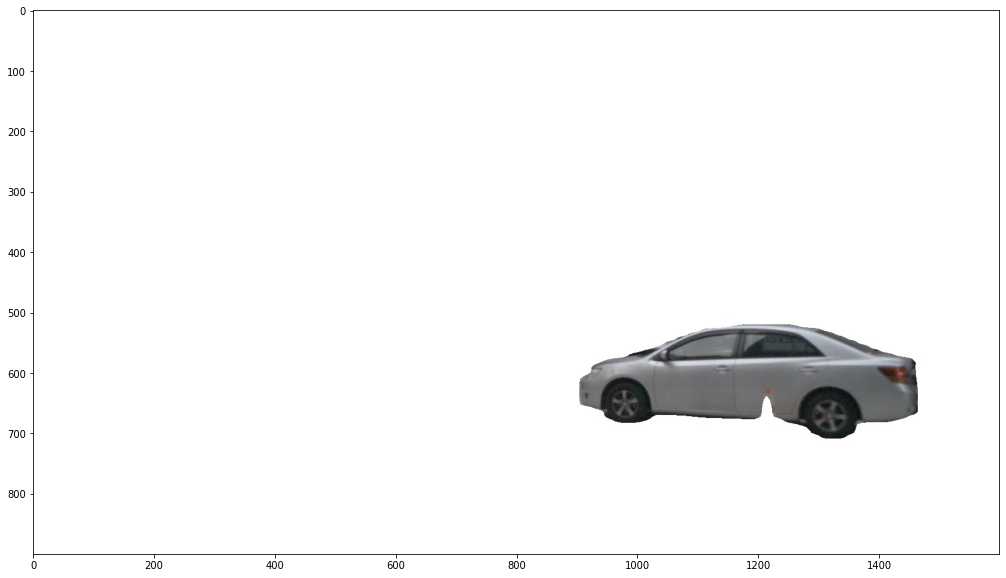

In [124]:
flipped_img = img[:,::-1,:]
plt.figure(figsize=(20,10))
plt.imshow(flipped_img)

### Symmetric camera

In [152]:
class Plane:
    def __init__(self, p1, p2, p3):
        p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
        v1 = p2 - p3
        v2 = p2 - p1
        normal = np.cross(v1, v2)
        self.normal = normal/np.linalg.norm(normal)
        self.k = -self.normal@p1
        self.sym_mat = self.get_sym_mat()
        print("Normal:", normal)
        print("k:", self.k)
        print("S:", self.sym_mat)
        print()
    
    def angle(self, vec):
        vec = np.array(vec)
        # angle with the normal of plane
        cos_theta = (vec @ self.normal) / np.linalg.norm(vec)
        return np.arccos(cos_theta)

    def dist(self, point):
        # dist from point to plane
        point = np.array(point)
        return np.abs(point @ self.normal + self.k) 
    
    def get_sym_mat(self):
        n = self.normal
        d = self.dist([0,0,0])
        S_R = np.eye(3)-2*np.outer(n,n)
        S_t = 2*d*n
        S = np.eye(4)
        S[:3,:3] = S_R
        S[:3,-1]=S_t
        return S
        

Normal: [-3.27796363  0.36333255  6.07279724]
k: -11.071425187263992
S: [[  0.55000155   0.04987825   0.83367287 -10.50325808]
 [  0.04987825   0.99447145  -0.09240508   1.16419092]
 [  0.83367287  -0.09240508  -0.544473    19.45846993]
 [  0.           0.           0.           1.        ]]



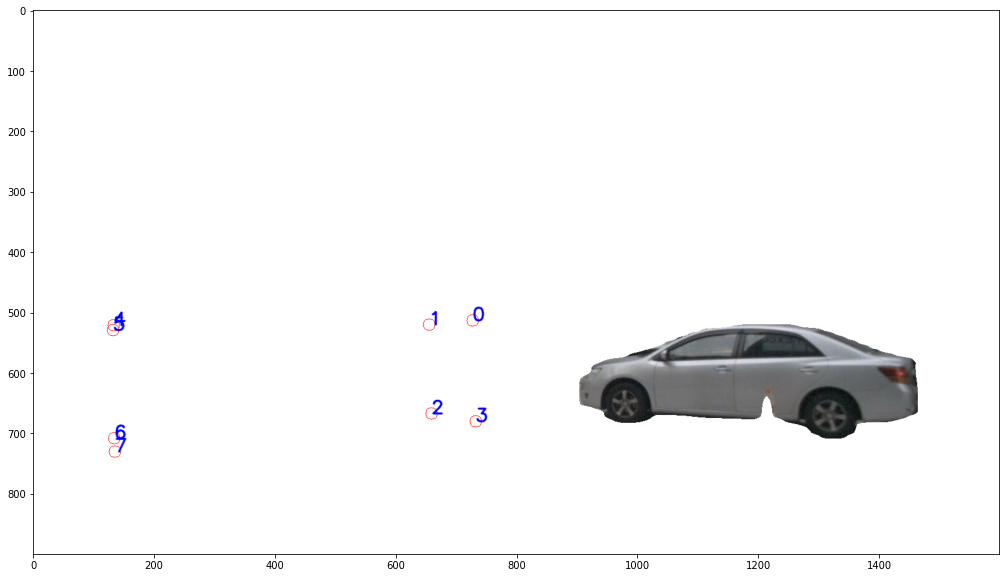

In [153]:
plane = Plane(*plane_points.T[:3].tolist())
sym_box_3d = np.ones((4,8))
sym_box_3d[:3,:] = box_3d
sym_box_3d = (plane.sym_mat@sym_box_3d)[:3,:]

# find pixels on the image
unnormalized_2d_points = (intrinsics@sym_box_3d).T
norm_2d_points = unnormalized_2d_points / unnormalized_2d_points[:,-1].reshape(len(unnormalized_2d_points),1)
norm_2d_points = norm_2d_points.astype("int")[:,:-1].tolist()
# visualize
draw_img = flipped_img.copy()
for i, point in enumerate(norm_2d_points):
    draw_img = cv2.circle(draw_img, tuple(point),10,(255,0,0))
    draw_img = cv2.putText(draw_img, str(i), tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0,0,255), 2, cv2.LINE_AA)

plt.figure(figsize=(20,10))
plt.imshow(draw_img)

In [154]:
Plane(*plane_points.T[[0,1,2]].tolist())
Plane(*plane_points.T[[0,1,3]].tolist())
Plane(*plane_points.T[[0,2,3]].tolist())
Plane(*plane_points.T[[1,2,3]].tolist())


Normal: [-3.27796363  0.36333255  6.07279724]
k: -11.071425187263992
S: [[  0.55000155   0.04987825   0.83367287 -10.50325808]
 [  0.04987825   0.99447145  -0.09240508   1.16419092]
 [  0.83367287  -0.09240508  -0.544473    19.45846993]
 [  0.           0.           0.           1.        ]]

Normal: [-3.27796363  0.36333255  6.07279724]
k: -11.071425187263992
S: [[  0.55000155   0.04987825   0.83367287 -10.50325808]
 [  0.04987825   0.99447145  -0.09240508   1.16419092]
 [  0.83367287  -0.09240508  -0.544473    19.45846993]
 [  0.           0.           0.           1.        ]]

Normal: [ 3.27796363 -0.36333255 -6.07279724]
k: 11.071425187263992
S: [[  0.55000155   0.04987825   0.83367287  10.50325808]
 [  0.04987825   0.99447145  -0.09240508  -1.16419092]
 [  0.83367287  -0.09240508  -0.544473   -19.45846993]
 [  0.           0.           0.           1.        ]]

Normal: [ 3.27796363 -0.36333255 -6.07279724]
k: 11.07142518726399
S: [[  0.55000155   0.04987825   0.83367287  10.5032